In [27]:
import numpy as np
import scipy.io as scio    
import os,re
from scipy import ndimage
from scipy import misc
from matplotlib import pyplot as plt

In [2]:
import keras

Using Theano backend.


In [3]:
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D,Concatenate
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau,CSVLogger
from keras import backend as keras

In [4]:
def atoi(text) : 
    return int(text) if text.isdigit() else text

In [5]:
def natural_keys(text) :
    return [atoi(c) for c in re.split('(\d+)', text)]

In [6]:
total_images = np.load('total_images.npy')
ground_truth_images = np.load('gt_labels_binary.npy')

In [7]:
root_path = "/home/pranathi/AI_Assignment2/"

In [8]:
def get_filenames(path):
    filenames = []
    for root, dirnames, filenames in os.walk(path):
        filenames.sort(key = natural_keys)
        rootpath = root
    print(len(filenames))
    return filenames

In [9]:
filenames_melanoma = get_filenames(root_path+"melanoma_resized/")
filenames_others = get_filenames(root_path+"others_resized/")

374
1626


In [10]:
filenames_total = filenames_melanoma+filenames_others
filenames_total.sort(key = natural_keys)

In [29]:
segmented_images = np.copy(total_images)
x,y,z = segmented_images[0].shape
for i in range(len(total_images)):
    for j in range(x):
        for k in range(y):
            for l in range(z):
                segmented_images[i][j][k][l] = total_images[i][j][k][l] if ground_truth_images[i][j][k]==1 else 0
    misc.imsave(root_path+"segmented_images/segmented_"+filenames_total[i],segmented_images[i])

In [30]:
segmented_images[0].shape

(128, 192, 3)

In [31]:
total_images.shape

(2000, 128, 192, 3)

In [32]:
ground_truth_images.shape

(2000, 128, 192)

In [33]:
np.save('segmented_images.npy',segmented_images)

In [34]:
classification_labels = np.zeros((len(total_images)))
i = 0
for file in filenames_total:
    if os.path.exists(root_path+"melanoma_resized/"+file):
        classification_labels[i]=0
    else:
        classification_labels[i]=1
    i+=1

In [35]:
print(classification_labels)

[ 1.  1.  0. ...,  1.  0.  1.]


In [36]:
np.save('classification_labels.npy',classification_labels)

In [37]:
train_indices = np.random.choice(2000,1900,replace=False)
print(len(train_indices))

1900


In [38]:
train_images = [segmented_images[i] for i in train_indices]
train_labels = [classification_labels[i] for i in train_indices]

In [39]:
print(len(train_images))
print(len(train_labels))

1900
1900


In [40]:
test_indices = [i for i in range(2000) if i not in train_indices]
print(len(test_indices))

100


In [41]:
test_images = [segmented_images[i] for i in test_indices]
test_labels = [classification_labels[i] for i in test_indices]

In [42]:
print(len(test_images))
print(len(test_labels))

100
100


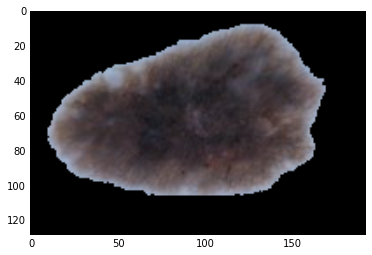

In [43]:
plt.imshow(segmented_images[0])
plt.show()

In [44]:
print(classification_labels[0])

1.0


In [45]:
image_dims = segmented_images[0].shape
print(image_dims)

(128, 192, 3)


In [46]:
train_mean = np.mean(train_images,axis = (0,1,2,3))
train_std = np.std(train_images,axis = (0,1,2,3))
train_images = (train_images - train_mean)/(train_std+1e-7)

In [47]:
test_mean = np.mean(test_images,axis=(0,1,2,3))
test_std = np.std(test_images,axis = (0,1,2,3))
test_images = (test_images-test_mean)/(test_std+1e-7)

In [49]:
np.save('classification_train_images.npy',train_images)
np.save('classification_test_images.npy',test_images)
np.save('classification_train_labels.npy',train_labels)
np.save('classification_test_labels.npy',test_labels)

In [ ]:
def get_unet_model(image_dims):
    inputs = Input((image_dims[0],image_dims[1],image_dims[2]))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = Concatenate(axis=3)([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    dense1 = Dense(1024)(conv9)
    output = Activation('softmax')
    
    model = Model(inputs = inputs, outputs = output)
    return model